# AutoInt example

## Imports

### A bunch of third-party libraries

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
from torch.utils.data import DataLoader
!pip install --no-dependencies torchmeta==1.4.6
!pip install ordered-set
!pip install colour
from torchmeta.modules import MetaModule

     |████████████████████████████████| 171 kB 7.5 MB/s 
  Created wheel for ordered-set: filename=ordered_set-4.0.2-py2.py3-none-any.whl size=8218 sha256=a3cf7f186fe1da66743eedf7791034de046b875e0bdfd561d009aed188a4f0c7
  Stored in directory: /root/.cache/pip/wheels/73/2b/f6/26e9f84153c25050fe7c09e88f8e32a6be3c7034a38c418319
Successfully built ordered-set
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchmeta 1.4.6 requires torch<1.6.0,>=1.4.0, but you have torch 1.9.0+cu102 which is incompatible.
torchmeta 1.4.6 requires torchvision<0.7.0,>=0.5.0, but you have torchvision 0.10.0+cu102 which is incompatible.


### Our libraries

In [3]:
import sys
import os

if not os.path.isdir('automatic-integration'):
    !git clone https://www.github.com/computational-imaging/automatic-integration
    %cd automatic-integration
    
from autoint.session import Session
import autoint.autograd_modules as autoint

Cloning into 'automatic-integration'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 72 (delta 27), reused 42 (delta 6), pack-reused 0
Unpacking objects: 100% (72/72), done.
/content/automatic-integration


## A class to create coordinates from a 1D function we wish to fit

In [4]:
class Implicit1DWrapper(torch.utils.data.Dataset):
    def __init__(self, range, fn, grad_fn=None, integral_fn=None, sampling_density=100,
                 train_every=10):

        avg = (range[0] + range[1]) / 2

        coords = self.get_samples(range, sampling_density)
        self.fn_vals = fn(coords)
        self.train_idx = torch.arange(0, coords.shape[0], train_every).float()

        #coords = (coords - avg) / (range[1] - avg)
        self.grid = coords
        self.grid.requires_grad_(True)
        #self.val_grid = val_coords

        if grad_fn is None:
            grid_gt_with_grad = coords
            grid_gt_with_grad.requires_grad_(True)
            fn_vals_with_grad = fn((grid_gt_with_grad * (range[1] - avg)) + avg)
            gt_gradient = torch.autograd.grad(fn_vals_with_grad, [grid_gt_with_grad],
                                              grad_outputs=torch.ones_like(grid_gt_with_grad), create_graph=True,
                                              retain_graph=True)[0]
            try:
                gt_hessian = torch.autograd.grad(gt_gradient, [grid_gt_with_grad],
                                                 grad_outputs=torch.ones_like(gt_gradient), retain_graph=True)[0]
            except Exception as e:
                gt_hessian = torch.zeros_like(gt_gradient)

        else:
            gt_gradient = grad_fn(coords) 
            gt_hessian = torch.zeros_like(gt_gradient)

        self.integral_fn = integral_fn
        if integral_fn:
            self.integral_vals = integral_fn(coords)

        self.gt_gradient = gt_gradient.detach()
        self.gt_hessian = gt_hessian.detach()

    def get_samples(self, range, sampling_density):
        num = int(range[1] - range[0])*sampling_density
        avg = (range[0] + range[1]) / 2
        coords = np.linspace(start=range[0], stop=range[1], num=num)
        coords.astype(np.float32)
        coords = torch.Tensor(coords).view(-1, 1)
        return coords

    def get_num_samples(self):
        return self.grid.shape[0]

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        if self.integral_fn is not None:
            return {'coords':self.grid}, {'integral_func': self.integral_vals, 'func':self.fn_vals,
                    'gradients':self.gt_gradient, 'val_func': self.val_fn_vals,
                    'val_coords': self.val_grid, 'hessian':self.gt_hessian}
        else:
            return {'idx': self.train_idx, 'coords':self.grid}, \
                   {'func': self.fn_vals, 'gradients':self.gt_gradient,
                    'coords': self.grid}

## Different 1D functions we want to integrate

In [63]:
def cos_fn(coords):
  return torch.cos(1*coords)

def polynomial_fn(coords):
    return .1*coords**5 - .2*coords**4 + .2*coords**3 - .4*coords**2 + .1*coords

def sinc_fn(coords):
    coords[coords == 0] += 1
    return torch.div(torch.sin(20*coords), 20*coords)

def linear_fn(coords):
    return 1.0 * coords

def xcosx_fn(coords):
    return coords * torch.cos(coords)

def integral_xcosx_fn(coords):
    return coords*torch.sin(coords) + torch.cos(coords)

def exp_fn(coords):
  return 2*coords*torch.exp(coords)

## Setting up the integral network & the grad network

We define an integral network using the AutoInt API. Here the integral network is a MLP with sine non-linearities: a SIREN.

In [6]:
class SIREN(MetaModule):
    def __init__(self, session):
        super().__init__()

        self.net = [] 
        self.input = autoint.Input(torch.Tensor(1, 1), id='x_coords')

        self.net.append(autoint.Linear(1, 128))
        self.net.append(autoint.Sine())
        self.net.append(autoint.Linear(128, 128))
        self.net.append(autoint.Sine())
        self.net.append(autoint.Linear(128, 128))
        self.net.append(autoint.Sine())
        self.net.append(autoint.Linear(128, 128))
        self.net.append(autoint.Sine())
        self.net.append(autoint.Linear(128, 1))

        self.net = torch.nn.Sequential(*self.net)
        self.session = session

    def input_init(self, input_tensor, m):
        with torch.no_grad():
            if isinstance(m, autoint.Input):
                m.set_value(input_tensor, grad=True)

    def constant_init(self, input_tensor, m):
        with torch.no_grad():
            if isinstance(m, autoint.Constant):
                m.set_value(input_tensor, grad=False)
    
    def forward(self, x):
        with torch.no_grad():
            input_init_func = partial(self.input_init, x[:, 0, None])
            self.input.apply(input_init_func)

        input_ctx = autoint.Value(x, self.session)

        out1 = self.input(input_ctx)
        return self.net(out1)

In AutoInt, a session will handle the derivation of the integral network into the grad network for you. It takes care of the reassembly of the weights too.

In [159]:
integralnet_session = Session()

Creating session: 8763342376869


We instantiate the integral net we defined earlier. The session can be thought as representing the integral network.

In [160]:
net = SIREN(integralnet_session)
net.cuda()

SIREN(
  (input): Input()
  (net): Sequential(
    (0): Linear()
    (1): Sine()
    (2): Linear()
    (3): Sine()
    (4): Linear()
    (5): Sine()
    (6): Linear()
    (7): Sine()
    (8): Linear()
  )
  (session): Session()
)

We can evaluate the SIREN we instantiated using the forward function as we would do for any Pytorch module.

In [162]:
x = torch.ones(1, 1).cuda() # defines a dummy input
y = torch.ones(1, 1).cuda()
x.requires_grad_(True)

session_input = {'x_coords': x,
                 #'y_coords': y,
                 'params': None}

y = net(x)

forward_siren_evaluation = y.data
print(f"result of forward SIREN evaluation={forward_siren_evaluation}")

result of forward SIREN evaluation=tensor([[-0.0059]], device='cuda:0', grad_fn=<AddBackward0>)


Evaluating the session also yields the output of the network. We must evaluate the session at least once (as done above) to initialize the session properly and get the backward session

In [163]:
integralnet_session_evaluation = integralnet_session(session_input)
print(f"result of forward session evaluation={integralnet_session_evaluation}")

result of forward session evaluation=tensor([[-0.0059]], device='cuda:0', grad_fn=<AddBackward0>)


We can check the two evaluations (the evaluation of the integral network via forward and of the session representing the integral network) are the same

In [164]:
error_fn = torch.nn.MSELoss()
print(f"Error between session and network evaluation={error_fn(forward_siren_evaluation.squeeze(), \
                                                               integralnet_session_evaluation.squeeze())}")

Error between session and network evaluation=0.0


Calling the function get_backward_graph() on the session instantiates another session that represents the grad network. **(this can only be done if the network has been run once!)**



In [165]:
gradnet_session = integralnet_session.get_backward_graph()

Creating session: 8763449502045


We can visualize the integral network we created (by visualizing its associated session)

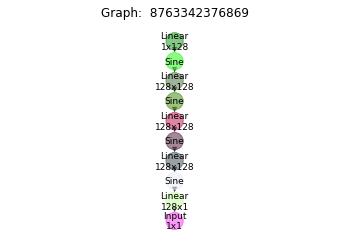

In [166]:
integralnet_session.draw()

We can also visualize the grad network (contained in the backward session):

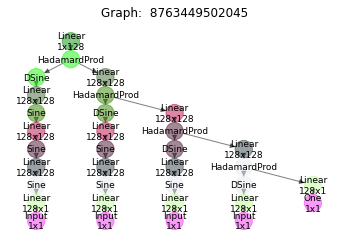

In [167]:
gradnet_session.draw()

## Fitting the grad network

We choose the function we want to calculate the integral using AutoInt.

In [168]:
func_to_fit = exp_fn

We create the dataloader that will create the pairs of datapoints of the form (input coordinate, output of the function to integrate) for us.

In [169]:
range1 = [0,2]

In [170]:
dataset = Implicit1DWrapper(range1, fn=func_to_fit, \
                            sampling_density=1000, train_every=1)
dataloader = DataLoader(dataset,shuffle=True, batch_size=1, \
                        pin_memory=True, num_workers=0)

def dict2cuda(d):
    tmp = {}
    for key, value in d.items():
        if isinstance(value, torch.Tensor):
            tmp.update({key: value.cuda()})
        else:
            tmp.update({key: value})
    return tmp

A minimal example of a training loop to fit the function:

In [180]:
epochs = 2000

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lr=5e-5, params=net.parameters(),amsgrad=True)

print_loss_every = 200

for e in range(epochs):
  for step, (input, gt) in enumerate(dataloader):
      input = dict2cuda(input)
      gt = dict2cuda(gt)
      
      gradnet_output = gradnet_session.compute_graph_fast({'x_coords': input['coords'],
                                                           'params': None})
      loss = loss_fn(gradnet_output,gt['func']).mean()

      optimizer.zero_grad()
      loss.backward()

      optimizer.step()
    
  if not e % print_loss_every:
      print(f"{e}/{epochs}: loss={loss}")

0/2000: loss=0.0006053638644516468
200/2000: loss=0.0010174462804570794
400/2000: loss=0.00030725289252586663
600/2000: loss=0.00018555093265604228
800/2000: loss=0.0001268674823222682
1000/2000: loss=0.0001791758550098166
1200/2000: loss=7.944663229864091e-05
1400/2000: loss=5.9738402342190966e-05
1600/2000: loss=4.864504444412887e-05
1800/2000: loss=4.130554589210078e-05


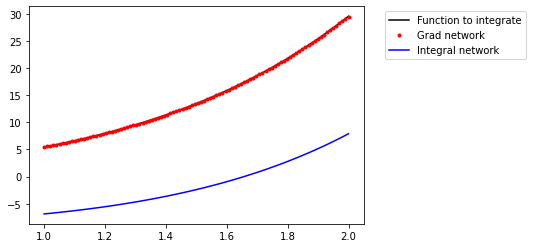

In [181]:
x_coords = torch.linspace(1,2,100)[:,None].cuda()
grad_vals = func_to_fit(x_coords).cpu()
fitted_grad_vals = gradnet_session.compute_graph_fast({'x_coords': x_coords,
                                                       'params': None}).cpu()
integral_vals = integralnet_session.compute_graph_fast({'x_coords': x_coords,
                                                        'params': None}).cpu()

x_coords = x_coords.cpu()
plt.plot(x_coords,grad_vals,'-k', label='Function to integrate')
plt.plot(x_coords,fitted_grad_vals.detach(),'.r', label='Grad network')
plt.plot(x_coords,integral_vals.detach(),'-b', label='Integral network')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')


In [182]:
gradnet_session.compute_graph_fast({'x_coords':torch.linspace(1,2,2)[:,None].cuda(), 'params':None }).cpu()

tensor([[ 5.4393],
        [29.4445]], grad_fn=<CopyBackwards>)

In [183]:
integral = integralnet_session.compute_graph_fast({'x_coords':torch.linspace(1,2,2)[:,None].cuda(),
                                                        'params': None}).cpu()

In [184]:
integral[1] - integral[0]

tensor([14.7780], grad_fn=<SubBackward0>)